In [63]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

In [64]:
data = pd.read_csv('data.csv', index_col = 0)

In [65]:
data = data.assign(Ret1M  = data.Close.groupby(data.Tick).pct_change(1))
data = data.assign(Ret3M  = data.Close.groupby(data.Tick).pct_change(3))
data = data.assign(Ret6M  = data.Close.groupby(data.Tick).pct_change(6))
data = data.assign(Ret12M = data.Close.groupby(data.Tick).pct_change(12))

In [66]:
data = data.assign(MOM3M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(4)  - 1)
data = data.assign(MOM6M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(6)  - 1)
data = data.assign(MOM12M = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(12) - 1)

In [67]:
# Changing "Date" to datetime format
data['Date'] = pd.to_datetime(data['Date'])

We have data about 209 stocks and 232 timepoints (months)
These are the columns in the dataset:

**'Tick' 'Date'   'Close'   'Mkt_Cap' 'P2B' 'Vol_1M' 'Div_yield' 'PE_ratio'**

 **'RSI_1M' 'D2E' 'Prof_growth' 'Ret_Cap' 'Asset_growth' 'Prof_Marg' 'Ret1M'**
 
 **'Ret3M' 'Ret6M' 'Ret12M' 'MOM3M' 'MOM6M' 'MOM12M'**

In [68]:
# See avaiable ticks
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(sorted(set(data.Tick)))

In [69]:
data.dropna(axis=0, how='any',inplace=True) # Drop first 12 rows since we dont' have some factors (e.g. ret12) # Also, we might now need data from 1999 to predict current movements

In [70]:
### From GitHub ###

#Sets index of dataframe to the stock's tick for sorting purposes
data.set_index("Tick",inplace=True)

#Extracts data for individual stock
def get_stock_data(data,stock):
    return data.loc[stock]


### Standardising the data - Cross sectional MinMax

In [71]:
%%capture
numeric_columns = list(data.columns.values[data.dtypes.values == float]) # Keeeping only numeric columns


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #Defyning the scalar object

def get_cross_section(data,date): # Used
    return data[data.Date == date]


standardized_data = pd.DataFrame(columns = list(data.columns.values).append("Quintile"))

for date in set(data.Date.values):
    CS_numeric_date = get_cross_section(data,date)[numeric_columns] # Extracting numeric columns from the cross section
    transformed = scaler.fit_transform(CS_numeric_date) # cross-sectional standardization
    scaled_features_df = pd.DataFrame(transformed, index=CS_numeric_date.index, columns=CS_numeric_date.columns) # transforming into dataframe
    scaled_features_df.insert(0, "Date", date) # Adding back the corresponding date
    
    
    ################ Calculating quintiles ##################
    q_20 = scaled_features_df["Ret1M"].quantile(q=0.2, interpolation='linear')
    q_40 = scaled_features_df["Ret1M"].quantile(q=0.4, interpolation='linear')
    q_60 = scaled_features_df["Ret1M"].quantile(q=0.6, interpolation='linear')
    q_80 = scaled_features_df["Ret1M"].quantile(q=0.8, interpolation='linear')
    
    # Encoding: 4 is in 1st quantile, 3 if in second quantile ...
    idx1 = np.where((scaled_features_df['Ret1M']<= q_20))
    idx2 = np.where((scaled_features_df['Ret1M']> q_20) & (scaled_features_df['Ret1M']<= q_40))
    idx3 = np.where((scaled_features_df['Ret1M']> q_40) & (scaled_features_df['Ret1M']<= q_60))
    idx4 = np.where((scaled_features_df['Ret1M']> q_60) & (scaled_features_df['Ret1M']<= q_80))
    idx5 = np.where((scaled_features_df['Ret1M']> q_80))
    
    scaled_features_df["Quintile"] = 999 # Initializing value
    scaled_features_df["Quintile"].iloc[idx1] = 0
    scaled_features_df["Quintile"].iloc[idx2] = 1
    scaled_features_df["Quintile"].iloc[idx3] = 2
    scaled_features_df["Quintile"].iloc[idx4] = 3
    scaled_features_df["Quintile"].iloc[idx5] = 4
    
    
    standardized_data = pd.concat([standardized_data, scaled_features_df]) # Adding the data from this date to the whole standardized database
    
    
standardized_data.sort_values(by=['Date'],inplace = True)

### Quintiles Check
I suggest to consider the quintiles as values and not as classes in the model. So that we can keep the information that 1s quintile > 2nd quintile > ... > 5th quintile

In [72]:
# Checking quintiles
standardized_data['Quintile'].value_counts()

# The higher the std 1 month returns, the higher the quintile value.
standardized_data[standardized_data['Date'] == date][["Ret1M","Quintile"]]

,Ret1M,Quintile
Tick,,
XRX,0.519769,0
AA,0.676183,1
MTW,0.800614,4
MUR,0.816520,4
MYL,0.782999,4
...,...,...
ETR,0.786441,4
F,0.656175,1
FAST,0.818582,4


### Shifting Quintiles to make predictions

In [228]:
%%capture
standardized_data_with_target = pd.DataFrame(columns = list(standardized_data.columns.values).append("Target_Shifted_Quintile_1"))

for tick in set(standardized_data.index.values):
    TS_tick = standardized_data[standardized_data.index == tick]
    
    
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick[["Quintile"]].shift(-1)
    TS_tick["Target_Shifted_Quintile_1"][-1] = 999 # Before converting to int we have to get rid of the nan (last value of the shifted)
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick["Target_Shifted_Quintile_1"].astype(int)
    
    standardized_data_with_target = pd.concat([standardized_data_with_target, TS_tick]) # Adding the data from this date to the whole standardized database
    
    
standardized_data_with_target["Temp"] = standardized_data_with_target.index
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.drop(['Temp'],axis='columns', inplace=True)

### Drop the last timestep - We don't have the target for it

In [229]:
standardized_data_with_target.reset_index(level=0, inplace=True)

standardized_data_with_target.drop(standardized_data_with_target[standardized_data_with_target.Target_Shifted_Quintile_1 == 999].index,axis='rows',inplace = True)

standardized_data_with_target.set_index("Tick",inplace = True)

### Define model

In [247]:
# RNN input_shape: (Samples,Time Steps, Features)
# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.

time_steps  = 2

input_shape=(time_steps, 20) # 1 or more samples, time_steps time steps, and 20 features.
# create and fit the LSTM network

reg_par = 0.006
model = Sequential()
model.add(LSTM(4, input_shape=input_shape,kernel_regularizer=l2(reg_par), recurrent_regularizer=l2(reg_par), bias_regularizer=l2(reg_par))) #activation="tanh" default
model.add(Dense(4))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.00004)
model.compile(loss='mean_squared_error', optimizer=opt)
print(model.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 4)                 400       
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 425
Trainable params: 425
Non-trainable params: 0
_________________________________________________________________
None


### Construct Dataset for model

In [248]:
#Separates data into target (Closing Price) and predictors (excluding date)
def split_stock_data(stock_data):
    y = stock_data['Target_Shifted_Quintile_1']
    X = stock_data.drop(['Target_Shifted_Quintile_1','Date'],axis='columns', inplace=False) #This way we don't remove the data information from the dataset
    return X,y



def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [249]:
stock = "INTC"


sd = get_stock_data(standardized_data_with_target,stock)
X,y  = split_stock_data(sd)

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y,test_size=0.125)

X_train,y_train = create_dataset(X_train, y_train, time_steps=time_steps)
X_test,y_test = create_dataset(X_test, y_test, time_steps=time_steps)
history = model.fit(X_train, y_train, epochs=400, batch_size=10, verbose=2,validation_split=0.125,shuffle = False,callbacks=[EarlyStopping(monitor='val_loss',patience=40, min_delta=0.0001)])

Epoch 1/400
17/17 - 0s - loss: 6.4973 - val_loss: 6.6392
Epoch 2/400
17/17 - 0s - loss: 6.4732 - val_loss: 6.6123
Epoch 3/400
17/17 - 0s - loss: 6.4492 - val_loss: 6.5855
Epoch 4/400
17/17 - 0s - loss: 6.4253 - val_loss: 6.5586
Epoch 5/400
17/17 - 0s - loss: 6.4013 - val_loss: 6.5317
Epoch 6/400
17/17 - 0s - loss: 6.3774 - val_loss: 6.5048
Epoch 7/400
17/17 - 0s - loss: 6.3535 - val_loss: 6.4778
Epoch 8/400
17/17 - 0s - loss: 6.3296 - val_loss: 6.4507
Epoch 9/400
17/17 - 0s - loss: 6.3056 - val_loss: 6.4235
Epoch 10/400
17/17 - 0s - loss: 6.2816 - val_loss: 6.3963
Epoch 11/400
17/17 - 0s - loss: 6.2575 - val_loss: 6.3689
Epoch 12/400
17/17 - 0s - loss: 6.2334 - val_loss: 6.3414
Epoch 13/400
17/17 - 0s - loss: 6.2093 - val_loss: 6.3139
Epoch 14/400
17/17 - 0s - loss: 6.1851 - val_loss: 6.2862
Epoch 15/400
17/17 - 0s - loss: 6.1608 - val_loss: 6.2583
Epoch 16/400
17/17 - 0s - loss: 6.1365 - val_loss: 6.2304
Epoch 17/400
17/17 - 0s - loss: 6.1121 - val_loss: 6.2024
Epoch 18/400
17/17 - 0s

Epoch 142/400
17/17 - 0s - loss: 3.2543 - val_loss: 3.0702
Epoch 143/400
17/17 - 0s - loss: 3.2381 - val_loss: 3.0540
Epoch 144/400
17/17 - 0s - loss: 3.2220 - val_loss: 3.0381
Epoch 145/400
17/17 - 0s - loss: 3.2061 - val_loss: 3.0223
Epoch 146/400
17/17 - 0s - loss: 3.1904 - val_loss: 3.0066
Epoch 147/400
17/17 - 0s - loss: 3.1749 - val_loss: 2.9912
Epoch 148/400
17/17 - 0s - loss: 3.1595 - val_loss: 2.9760
Epoch 149/400
17/17 - 0s - loss: 3.1444 - val_loss: 2.9609
Epoch 150/400
17/17 - 0s - loss: 3.1294 - val_loss: 2.9460
Epoch 151/400
17/17 - 0s - loss: 3.1146 - val_loss: 2.9314
Epoch 152/400
17/17 - 0s - loss: 3.0999 - val_loss: 2.9169
Epoch 153/400
17/17 - 0s - loss: 3.0855 - val_loss: 2.9026
Epoch 154/400
17/17 - 0s - loss: 3.0713 - val_loss: 2.8886
Epoch 155/400
17/17 - 0s - loss: 3.0572 - val_loss: 2.8747
Epoch 156/400
17/17 - 0s - loss: 3.0434 - val_loss: 2.8610
Epoch 157/400
17/17 - 0s - loss: 3.0297 - val_loss: 2.8475
Epoch 158/400
17/17 - 0s - loss: 3.0162 - val_loss: 2.83

Epoch 281/400
17/17 - 0s - loss: 2.4719 - val_loss: 2.3308
Epoch 282/400
17/17 - 0s - loss: 2.4715 - val_loss: 2.3306
Epoch 283/400
17/17 - 0s - loss: 2.4711 - val_loss: 2.3304
Epoch 284/400
17/17 - 0s - loss: 2.4707 - val_loss: 2.3302
Epoch 285/400
17/17 - 0s - loss: 2.4703 - val_loss: 2.3300
Epoch 286/400
17/17 - 0s - loss: 2.4699 - val_loss: 2.3298
Epoch 287/400
17/17 - 0s - loss: 2.4695 - val_loss: 2.3297
Epoch 288/400
17/17 - 0s - loss: 2.4691 - val_loss: 2.3295
Epoch 289/400
17/17 - 0s - loss: 2.4688 - val_loss: 2.3293
Epoch 290/400
17/17 - 0s - loss: 2.4684 - val_loss: 2.3292
Epoch 291/400
17/17 - 0s - loss: 2.4681 - val_loss: 2.3290
Epoch 292/400
17/17 - 0s - loss: 2.4677 - val_loss: 2.3289
Epoch 293/400
17/17 - 0s - loss: 2.4674 - val_loss: 2.3288
Epoch 294/400
17/17 - 0s - loss: 2.4670 - val_loss: 2.3286
Epoch 295/400
17/17 - 0s - loss: 2.4667 - val_loss: 2.3285
Epoch 296/400
17/17 - 0s - loss: 2.4664 - val_loss: 2.3283
Epoch 297/400
17/17 - 0s - loss: 2.4661 - val_loss: 2.32

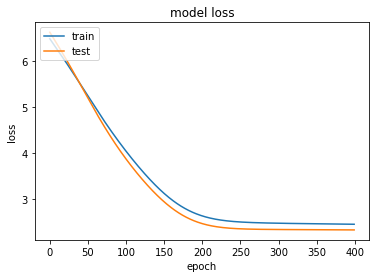

In [250]:
#  print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [251]:
from sklearn.metrics import r2_score

predictions = model.predict(x=X_test, batch_size=4, verbose=0) 
rounded_predictions = np.array([int(i[0]) for i in np.round(predictions).tolist()])
score = r2_score(y_test, rounded_predictions)
print("Predictions            :   ",rounded_predictions)
print("Actual                 :   ",y_test)
print("R-squared              :   ",score)



Predictions            :    [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Actual                 :    [3 1 1 3 1 1 0 4 1 3 2 3 1 0 0 3 0 4 3 0 1 3 0 2 1 3]
R-squared              :    -0.054054054054053946


In [222]:
# Values count
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0 8]
 [1 6]
 [2 2]
 [3 3]
 [4 7]]


In [223]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [224]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
print(cm)

[[0 2 3 3 0]
 [0 3 0 3 0]
 [0 0 1 0 1]
 [0 1 2 0 0]
 [1 2 2 2 0]]


In [225]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 1 2 1 0]
 [0 1 5 1 0]
 [0 0 2 0 0]
 [0 0 1 0 2]
 [0 0 4 4 2]]


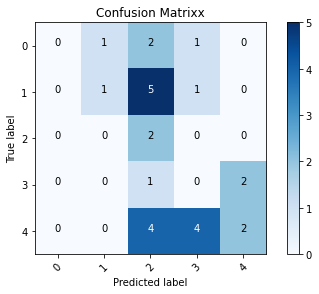

In [216]:
cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrixx')